# Flow past a flat plate 

In [1]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
using ProgressMeter
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create the plate

In [9]:
b = let Npts = 230,  # number of points on each flat side of plate
        len = 1.0,   # length of the plate
        thick = 0.023, # thickness
        λ = 1.0, #thick/len,  # a parameter that controls the ratio of spacing of points on plate
        xcent = [0.0,0.0], # initial centroid of the body
        ang = -35π/180  # initial orientation of the body
        Bodies.Plate(Npts,len,thick,λ,xcent,ang)
end

Body: number of points = 476, reference point = (0.0,0.0), rotation matrix = [0.819152 0.573576; -0.573576 0.819152]
     max spacing between points = 0.004400859472198546
     min spacing between points = 0.0043478260869563735


### Or create an infinitely thin plate

In [45]:
bthin = let Npts = 140,  # number of points on each flat side of plate
        len = 1.0,   # length of the plate
        λ = 1.0, # a parameter that controls the ratio of spacing of points on plate
        xcent = [0.0,0.0], # initial centroid of the body
        ang = -20π/180  # initial orientation of the body
        Bodies.Plate(Npts,len,λ,xcent,ang)
end

Body: number of points = 140, reference point = (0.0,0.0), rotation matrix = [0.939693 0.34202; -0.34202 0.939693]
     max spacing between points = 0.00714285714285725
     min spacing between points = 0.007142857142857079


### Create a domain with this body in it

In [10]:
dom = let xmin = [-1.0,-1.0], # minimum dimensions of domain
          xmax = [2.0,1.0]   # maximum dimensions of domain
        Systems.DualDomain(xmin,xmax)
end

# Add the body to the domain
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [2.0, 1.0]
number of bodies = 1
Body: number of points = 476, reference point = (0.0,0.0), rotation matrix = [0.819152 0.573576; -0.573576 0.819152]
     max spacing between points = 0.004400859472198546
     min spacing between points = 0.0043478260869563735



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [11]:
Δx = 0.005
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [2.0, 1.0]
number of bodies = 1
Body: number of points = 476, reference point = (0.0,0.0), rotation matrix = [0.819152 0.573576; -0.573576 0.819152]
     max spacing between points = 0.004400859472198546
     min spacing between points = 0.0043478260869563735

Grid: number of cells = (600,400), Δx = 0.005, xmin = [-1.0, -1.0], xmax = [2.0, 1.0]



### Set the physical and time parameters

In [14]:
Re = 500
physparams = let U = [1.0,0.0]
    NavierStokes.set_freestream(U)
end
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
println(tparams)
println("α = $(α)")

Time step size 0.0025
α = 0.19999999999999998


### Set the filename base for this case

In [15]:
filebase = "Plate35degRe500dx005refine"

"Plate35degRe500dx005refine"

### Setting up a new problem

#### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [16]:
gops, ops = NavierStokes.set_operators_body!(dom,params);

Setting up LGF table
  4.897084 seconds (3.27 M allocations: 3.509 GiB, 9.34% gc time)
Setting up integrating factor table
  0.184761 seconds (38.79 k allocations: 22.719 MiB, 54.28% gc time)
Setting up body-to-grid operator


Computing Eᵀ...100%|████████████████████████████████████| Time: 0:00:24
Computing CᵀEᵀx...100%|█████████████████████████████████| Time: 0:00:08
Computing CᵀEᵀy...100%|█████████████████████████████████| Time: 0:00:08


 70.162543 seconds (798.68 k allocations: 25.302 GiB, 3.61% gc time)
Computing Schur complements and inverses
263

Computing G̃ᵀẼᵀ...100%|████████████████████████████████| Time: 0:00:29


.673711 seconds (452.39 k allocations: 8.668 GiB, 0.29% gc time)
131.375941 seconds (37.64 k allocations: 6.922 GiB, 0.44% gc time)


#### Write domain data, operators and parameters to file

In [17]:
setupfile = filebase*".setup"
fid = open(setupfile,"w")
Serializer.serialize(fid,(gops,ops.S⁻¹,ops.S₀⁻¹,dom,params,tparams))
close(fid)
println("Writing the operators to file "*setupfile)

Writing the operators to file Plate35degRe500dx005refine.setup


#### Create an initial solution structure

In [18]:
s = NavierStokes.BodySoln(dom)
h = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Float64,2},Array{Float64,2}},1}:
 Solution: t = 0.0


### Restarting an old case

#### Read domain data, operators and parameters from file

In [80]:
setupfile = filebase*".setup"
fid = try
    open(setupfile,"r")
catch
    -1
    #println("File "*setupfile*" does not exist")
end
if isa(fid,IOStream)
    gops,S⁻¹,S₀⁻¹,dom,params,tparams = Serializer.deserialize(fid);
    Grids.setFFTPlan!(dom.grid)
    gops, ops = NavierStokes.set_operators_body!(dom,params,S⁻¹,S₀⁻¹);
    close(fid)
    println("Loaded the operators from file "*setupfile)
end

Loaded the operators from file Plate45degRe500dx005smooth.setup


#### Read solution data from file

In [89]:
datafile = filebase*".soln"
fid = try
        open(datafile,"r")
catch
    -1
    #println("File "*datafile*" does not exist")
end
if isa(fid,IOStream)
    h = Serializer.deserialize(fid)
    close(fid)
    s = h[end]
    println("Loaded the solution data from file "*datafile)
end

Loaded the solution data from file Plate15degRe500dx005.soln


### Advance the solution

In [19]:
@showprogress 1 "Computing..." for i = 1:400
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

Computing...100%|███████████████████████████████████████| Time: 0:13:22


Solution: t = 0.9999999999999897


#### Write solution data to file

In [20]:
datafile = filebase*".soln"
fid = open(datafile,"w")
Serializer.serialize(fid,h)
close(fid)
println("Writing the solution data to file "*datafile)

Writing the solution data to file Plate35degRe500dx005refine.soln


### Evaluate and plot the force history

In [90]:
tforce, fx, fy = NavierStokes.force(h,dom.grid);

In [91]:
tforce15 = tforce;
fx15 = fx;
fy15 = fy;

In [203]:
d=Dict()
for α in 15:5:45
    d["t"*string(α)] = eval(Symbol("tforce",α)) #*sin(2*α*pi/180)
    d["Cn"*string(α)] = 2*(eval(Symbol("fx",α))*sin(α*pi/180)+eval(Symbol("fy",α))*cos(α*pi/180)) #/sin(α*pi/180);
end

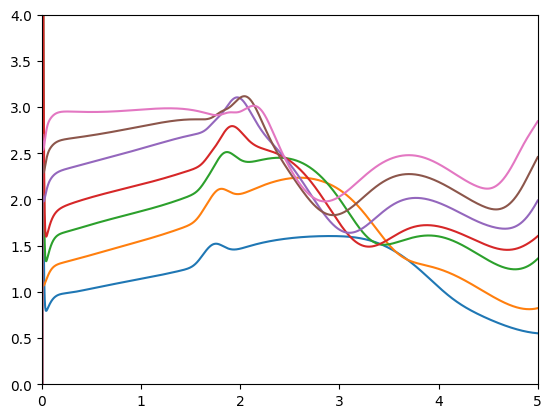

(0, 5.0)

In [205]:
for α in 15:5:45
    plot(d["t"*string(α)],d["Cn"*string(α)])
end
ylim(0,4)
xlim(0,5.0)

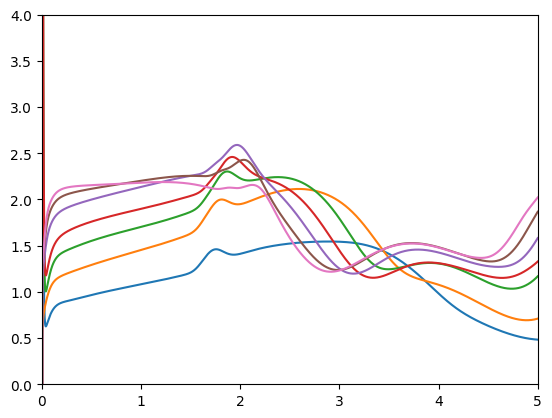

(0, 5.0)

In [184]:
plot(tforce15,2*fy15,tforce20,2*fy20,tforce25,2*fy25,tforce30,2*fy30,tforce35,2*fy35,tforce40,2*fy40,tforce45,2*fy45)
#plot(tforce45,2*fy45,tforce45s,2*fy45s)
ylim(0,4)
xlim(0,5.0)

In [183]:
plot(tforce15,2*fy15,tforce20s,2*fy20s,tforce25,2*fy25,tforce30,2*fy30,tforce35s,2*fy35s,tforce40s,2*fy40s,tforce45s,2*fy45s)
#plot(tforce45,2*fy45,tforce45s,2*fy45s)
ylim(0,4)
xlim(0,5.0)
savefig("CLAlpha",format="pdf")

LoadError: [91mUndefVarError: tforce20s not defined[39m

In [1082]:
tforce40s = deepcopy(tforce);
fx40s = deepcopy(fx);
fy40s = deepcopy(fy);

In [431]:
tforce45 = deepcopy(tforce500);
fx45 = deepcopy(fx500);
fy45 = deepcopy(fy500);

### Evaluate the fields in the solution history

In [21]:
@time f = NavierStokes.evaluateFields.(h[end-1:end],dom.grid,gops);
t = map(x -> x.t, f);
ω = map(x -> x.ω, f);
ψ = map(x -> x.ψ, f);
ux = map(x -> x.ux, f);
uy = map(x -> x.uy, f);

xc = Grids.xcell(dom.grid);
yc = Grids.ycell(dom.grid);

  2.402101 seconds (282.19 k allocations: 66.441 MiB, 0.73% gc time)


#### Evaluate at a specific time

In [32]:
teval = 1.0
@time f = NavierStokes.evaluateFields(h(teval),dom.grid,gops);
t = f.t
ω = f.ω
ψ = f.ψ
ux = f.ux
uy = f.uy
xc = Grids.xcell(dom.grid);
yc = Grids.ycell(dom.grid);

  0.170613 seconds (1.69 k allocations: 29.645 MiB, 6.50% gc time)


### Plot the fields

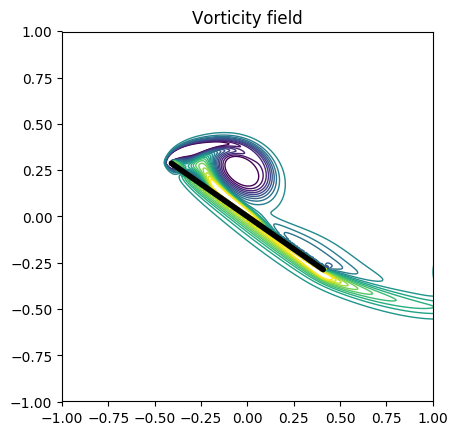

In [33]:
contour(xc,yc,transpose(ω),linspace(-20,20,20),linewidths=1)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
xlim(-1,1)
title("Vorticity field")
vortfile = filebase*"T"@sprintf("%5.0f",10000+100*f.t)[2:end]*".pdf"
savefig(vortfile,format="pdf")

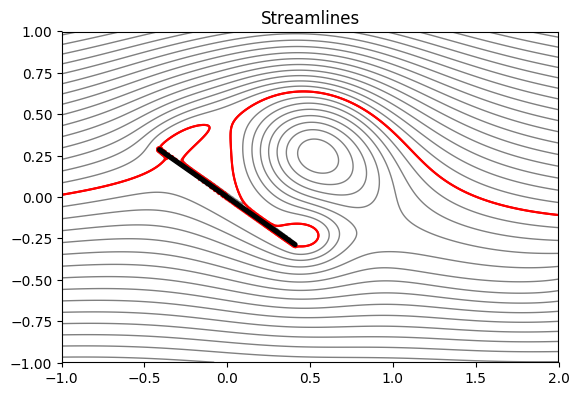

In [1427]:
PyPlot.rc("contour",negative_linestyle="solid")
ph = contour(xc,yc,yc.+transpose(ψ),31,colors="gray",linewidths=1)

spts = Process.SamplePoint(dom.body[1].x[1][1],dom.body[1].x[1][2])
ψsamp = Process.sample(spts,ψ,xc,yc).+spts.y
contour(xc,yc,yc.+transpose(ψ),[floor(ψsamp[1][1]*1e4)/1e4,ceil(ψsamp[1][1]*1e4)/1e4],colors="r")

for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamlines")
streamfile = filebase*"T"@sprintf("%5.0f",10000+100*f.t)[2:end]*"SF.pdf"
savefig(streamfile,format="pdf")

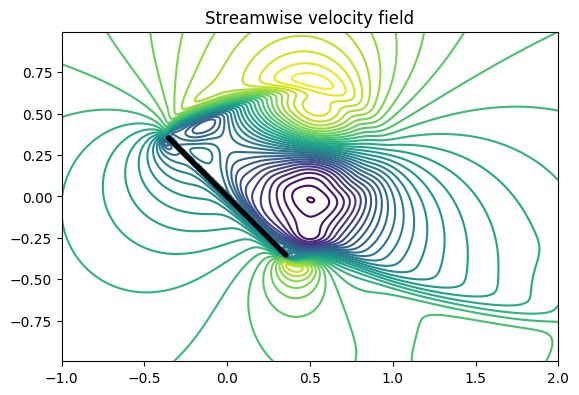

PyObject <matplotlib.text.Text object at 0x12c183950>

In [54]:
contour(Grids.xfacex(dom.grid),Grids.yfacex(dom.grid),transpose(ux[end]).+1,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamwise velocity field")

### Evaluate the surface tractions

In [1535]:
norms = [map(x -> x[1], Bodies.normal(dom.body[1])) map(x -> x[2], Bodies.normal(dom.body[1]))]
tract = h(teval).f*dom.grid.Δx^2./Bodies.ds(dom.body[1])
press = -sum(tract.*norms,2);
ds = Bodies.ds(dom.body[1]);
ssurf = cumsum([0; 0.5*(ds[1:dom.body[1].N-1]+ds[2:dom.body[1].N])]);
itop = find([dom.body[1].config.rot[:,2]'*norms[i,:]==1.0 for i = 1:dom.nbodypts]);
ibot = find([dom.body[1].config.rot[:,2]'*norms[i,:]==-1.0 for i = 1:dom.nbodypts]);

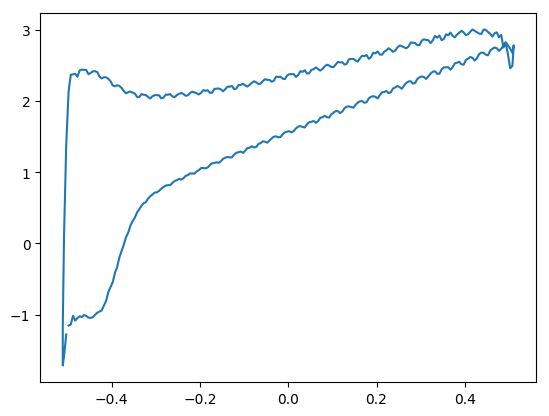

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0xafcf9be90>

In [1537]:
plot(xtilde,press)
#ylim(-3,3)

In [818]:
dom.grid.node = zeros(Float64,dom.grid.N[1]+1,dom.grid.N[2]+1);

In [1742]:
#teval = 0.2
ux,uy = Grids.curl(dom.grid,-gops.L⁻¹(h(teval).u))
vx,vy = Grids.shift(dom.grid,ux,uy) # vx is x velocity at dual x faces, 
wx,wy = Grids.shift(dom.grid,h(teval).u) # wx is w at the dual x faces, wy is w at the dual y faces
f̃ = h(teval).f
fx,fy = reshape(dom.Eᵀ[1]*f̃[:,1],size(dom.grid.facex)),reshape(dom.Eᵀ[2]*f̃[:,2],size(dom.grid.facey))
divwxu = Grids.diverg(dom.grid,-vy.*wy+fx,(vx.+1.0).*wx+fy);
divwxu = [divwxu zeros(dom.grid.N[1]+1,1); zeros(1,dom.grid.N[2]+2)];
ptotbig = -gops.L⁻¹(divwxu)*dom.grid.Δx
ptot = ptotbig[1:dom.grid.N[1]+1,1:dom.grid.N[2]+1]
#ptotcell = 0.25*(ptot[1:dom.grid.N[1],1:dom.grid.N[2]]+ptot[2:dom.grid.N[1]+1,1:dom.grid.N[2]]+ptot[1:dom.grid.N[1],2:dom.grid.N[2]+1]+ptot[2:dom.grid.N[1]+1,2:dom.grid.N[2]+1]);
vxnode = 0.5*(ux[1:dom.grid.N[1]+1,:]+ux[2:dom.grid.N[1]+2,:]) + 1.0;
vynode = 0.5*(uy[:,1:dom.grid.N[2]+1]+uy[:,2:dom.grid.N[2]+2]);
#vxcell = 0.5*(ux[2:dom.grid.N[1]+1,1:dom.grid.N[2]]+ux[2:dom.grid.N[1]+1,2:dom.grid.N[2]+1]) + 1.0;
#vycell = 0.5*(uy[1:dom.grid.N[1],2:dom.grid.N[2]+1]+uy[2:dom.grid.N[1]+1,2:dom.grid.N[2]+1]);
p = ptot - 0.5*(vxnode.^2+vynode.^2);
#pcell = ptotcell - 0.5*(vxcell.^2+vycell.^2);
#pcellbig = [zeros(1,dom.grid.N[2]+2); zeros(dom.grid.N[1],1) pcell zeros(dom.grid.N[1],1); zeros(1,dom.grid.N[2]+2)]
psurf = dom.Ẽᵀ[2]'*reshape(p,length(dom.grid.node));
#psurfcell = dom.Ẽᵀ[1]'*reshape(pcellbig,length(dom.grid.cell));
iplus(i,n) = 1 + mod(i+n-1,dom.body[1].N)
psurfavg = [(psurf[iplus(i,2)]+psurf[iplus(i,1)]+psurf[i]+psurf[iplus(i,-1)]+psurf[iplus(i,-2)])/5 for i = 1:dom.body[1].N];
#psurfcellavg = [(psurfcell[iplus(i,2)]+psurfcell[iplus(i,1)]+psurfcell[i]+psurfcell[iplus(i,-1)]+psurfcell[iplus(i,-2)])/5 for i = 1:dom.body[1].N];
p = p[2:dom.grid.N[1],2:dom.grid.N[2]];

In [1559]:
imin = find(xtilde.==minimum(xtilde))[end];
imax = find(xtilde.==maximum(xtilde))[1];
itop = imax<imin?[imin:length(xtilde);1:imax]:(imin:imax);
ibot = imax<imin?(imax:imin):[imax:length(xtilde);1:imin];

In [1786]:
spts = Process.SamplePoints(xsurf,ysurf);
psamp = Process.sample(spts,p,xnode,ynode);
psampavg = [(psamp[iplus(i,2)][1]+psamp[iplus(i,1)][1]+psamp[i][1]+psamp[iplus(i,-1)][1]+psamp[iplus(i,-2)][1])/5 for i = 1:dom.body[1].N];

In [1766]:
xtilde = map(x -> x[1],dom.body[1].xtilde);
ytilde = map(x -> x[2],dom.body[1].xtilde);
xsurf = map(x -> x[1],dom.body[1].x);
ysurf = map(x -> x[2],dom.body[1].x);

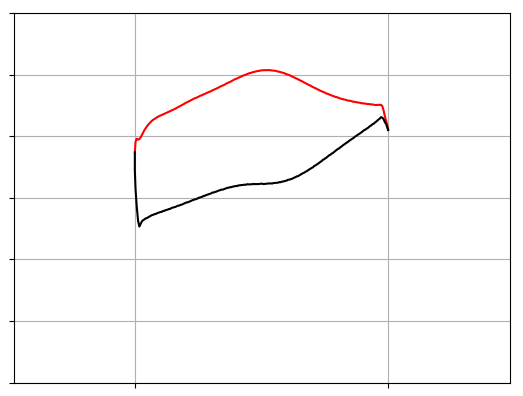

In [1796]:
plot(xtilde[itop],-(psurfavg[itop]-mean(psurfavg)),color="red")
plot(xtilde[ibot],-(psurfavg[ibot]-mean(psurfavg)),color="black")
ylim(-2,1)
#xlim(minimum(xtilde),maximum(xtilde))
xlim(-1,1)
xticks([minimum(xtilde),maximum(xtilde)],[])
yticks(-2:0.5:1,[])
grid("on")
pfile = filebase*"T"@sprintf("%5.0f",10000+100*h(teval).t)[2:end]*"P.pdf"
savefig(pfile,format="pdf")

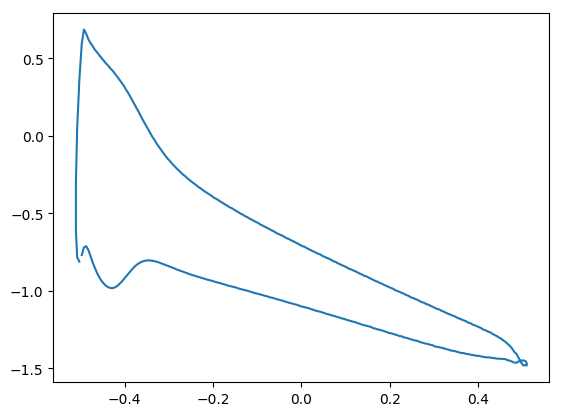

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0xb04506c90>

In [1534]:
plot(xtilde,psurfavg)

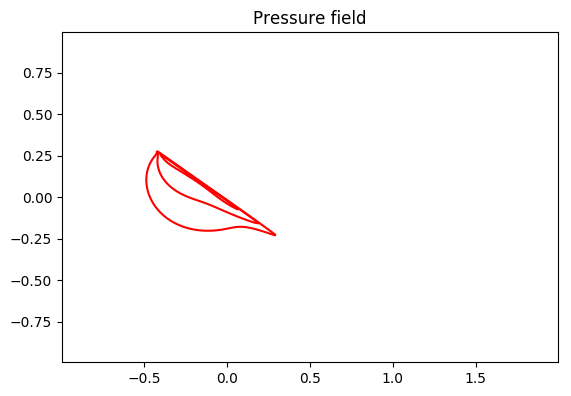

PyObject <matplotlib.text.Text object at 0xb0cdc13d0>

In [1795]:
contour(xnode,ynode,transpose(p).-mean(psurfavg),linspace(1.5,2,3),colors="r")
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    #plot(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
#xlim(0.0,0.5)
#ylim(-0.25,0.0)
title("Pressure field")

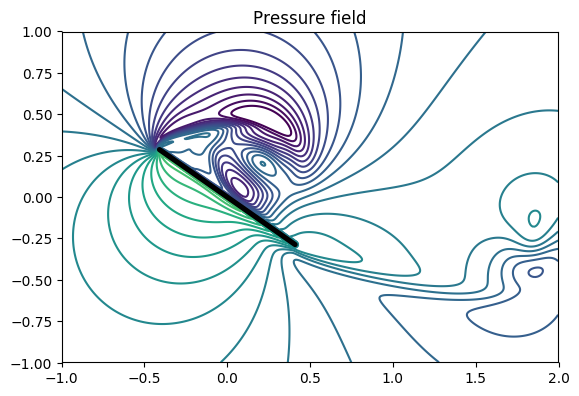

PyObject <matplotlib.text.Text object at 0xb02fb3c90>

In [1728]:
contour(xc,yc,transpose(pcell),linspace(-2,2,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Pressure field")